In [1]:
import pandas as pd
import vertica_python
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [2]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

# Queries
* * *
### Overall Completion Rate

In [3]:
#DROP TABLE IF EXISTS ahemphill.course_run_length;
#CREATE TABLE ahemphill.course_run_length AS#

#SELECT
#	a.course_id,
#	a.catalog_course_title,
#	a.level_type,
#	b.subject_title,
#	a.start_time,
#	a.end_time,
#	DATEDIFF(day, a.start_time, a.end_time) AS course_run_days
#FROM
#	production.d_course a
#LEFT JOIN
#	production.d_course_subjects b
#ON 
#	a.course_id = b.course_id
#WHERE
#	a.pacing_type = 'instructor_paced'
#	AND a.availability = 'Archived';#
#

#DROP TABLE IF EXISTS ahemphill.completion_rate_all;
#CREATE TABLE ahemphill.completion_rate_all AS
#	SELECT
#		a.user_id,
#		a.course_id,
#		a.current_enrollment_mode,
#		a.first_enrollment_mode,
#		a.first_enrollment_time,
#		b.catalog_course_title,
#		b.end_time AS end_time_from_d_course,
#		c.enddate AS end_time_ed_services_table,
#		d.certificate_mode,
#		d.has_passed
#	FROM
#		production.d_user_course a	
#	LEFT JOIN
#		production.d_course b
#	ON
#	       a.course_id = b.course_id
#	LEFT JOIN
#	       ed_services.CourseCatalog_20161010 c
#	ON
#	       a.course_id = c.CourseID
#	LEFT JOIN
#	    production.d_user_course_certificate d
#	ON     
#	    a.user_id = d.user_id
#	    AND a.course_id = d.course_id
#	WHERE
#		b.pacing_type = 'instructor_paced'
#		AND a.first_enrollment_time <= c.enddate
#		AND a.first_enrollment_time IS NOT NULL


In [4]:
completion_rate_query = """

SELECT
	c.course_id,
	c.catalog_course_title,
    p.subject_title,
	p.level_type,
	p.course_run_days,
	SUM(c.has_passed)*100.0/COUNT(1) AS completion_percentage,
	SUM(c.has_passed) AS total_completions,
	COUNT(1) AS total_enrollments
FROM ahemphill.completion_rate_all c
LEFT JOIN ahemphill.course_run_length p
ON c.course_id = p.course_id

GROUP BY 
    c.course_id,
    c.catalog_course_title,
    p.subject_title,
    	p.level_type,
	p.course_run_days


"""

In [5]:
connection = vertica_python.connect(**conn_info)
    
cur = connection.cursor('dict')
cur.execute(completion_rate_query)
extract = cur.fetchall()
completion_rate_df = pd.DataFrame(extract)


connection.close()

In [6]:
completion_rate_df.head()

,catalog_course_title,completion_percentage,course_id,course_run_days,level_type,subject_title,total_completions,total_enrollments
0,The Chemistry of Life,1.2120258145757909649,course-v1:KyotoUx+001x+1T2016,105.0,Introductory,Biology & Life Sciences,77.0,6353
1,Japanese Pronunciation for Communication,None,course-v1:WasedaX+JPC111x+3T2016,NaN,None,None,NaN,7495
2,Supply Chain and Logistics Fundamentals,6.6013783097569822271,MITx/ESD.SCM1x/3T2014,85.0,Introductory,None,2184.0,33084
3,Library Advocacy Unshushed,7.6846637959589267970,University_of_TorontoX/LA101x_2/1T2015,49.0,Introductory,Social Sciences,232.0,3019
4,Management Accounting,None,course-v1:ACCA+FMA-F2.x+3T2016,NaN,None,None,NaN,177


In [7]:
completion_rate_df_filtered = completion_rate_df.query('course_run_days>0').query('course_run_days<180')

In [8]:
completion_rate_df_filtered['completion_percentage']=completion_rate_df_filtered.completion_percentage.astype('float')

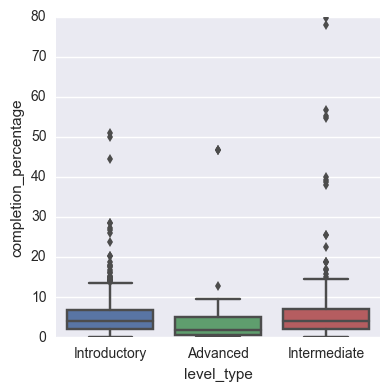

In [38]:
sns.factorplot(data= completion_rate_df_filtered, x="level_type", y="completion_percentage", kind = 'box')

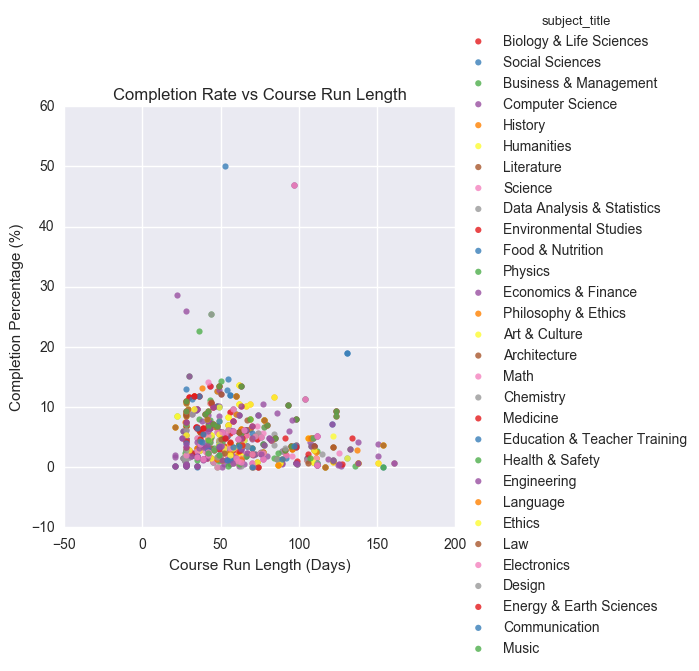

In [35]:
sns.lmplot(data = completion_rate_df_filtered, x = 'course_run_days', y = 'completion_percentage', hue='subject_title',
           fit_reg=False, palette="Set1"
          )
plt.title('Completion Rate vs Course Run Length')
plt.xlabel('Course Run Length (Days)')
plt.ylabel('Completion Percentage (%)')

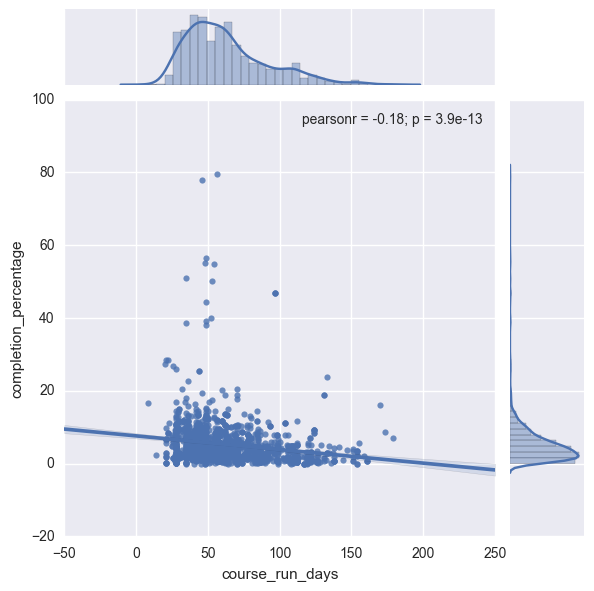

In [21]:
sns.jointplot(data = completion_rate_df_filtered, x="course_run_days", y="completion_percentage", kind="reg")


In [ ]:
sns.jointplot(data = completion_rate_df_filtered, x="course_run_days", y="completion_percentage", kind="reg")

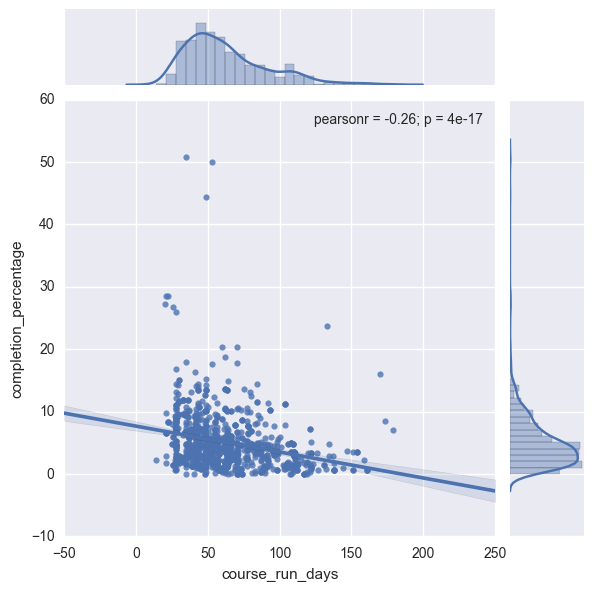

In [31]:
ax = sns.jointplot(data = completion_rate_df_filtered[completion_rate_df_filtered.level_type=='Introductory'], x="course_run_days", 
                    y="completion_percentage", kind="reg")

In [33]:
completion_rate_df_data = completion_rate_df_filtered[completion_rate_df_filtered['subject_title']=='Data Analysis & Statistics']

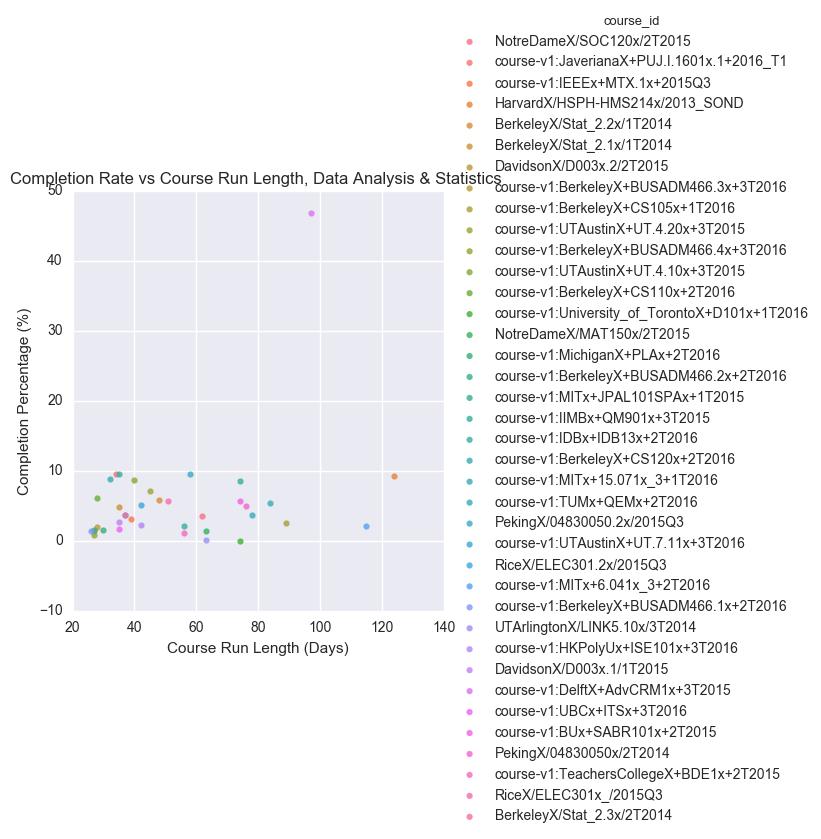

In [39]:
sns.lmplot(data = completion_rate_df_data, x = 'course_run_days', y = 'completion_percentage', fit_reg=False
          ,hue = 'course_id')
plt.title('Completion Rate vs Course Run Length, Data Analysis & Statistics ')
plt.xlabel('Course Run Length (Days)')
plt.ylabel('Completion Percentage (%)')